In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('booksummaries.txt', sep='\t',
                 names=['id1', 'id2', 'title', 'author', 'year', 'genres', 'summary'],
                 usecols=[2, 3, 5, 6], converters={'genres' : lambda s : (list(json.loads(s).values()) if s else None)})

In [12]:
valid_genres = ['Science Fiction','Crime Fiction','Children\'s literature',
                'Fantasy', 'Young adult literature']

In [13]:
# Iterate through each row to extract and split the list of genres
book_list = []

# Iterate through each element in the 'genres_column'
for i, row in df.iterrows():
    if row["genres"]:
        for genre in valid_genres:
            new_row={
                "title": row["title"],
                "author": row["author"],
                "summary": row["summary"]
                }
            genre_list=row["genres"]
            if genre in genre_list:
                new_row["genre"]=genre
                book_list.append(new_row)
book_df = pd.DataFrame(book_list)

In [14]:
book_df = book_df.drop_duplicates(subset=['title'])

In [15]:
book_df

,title,author,summary,genre
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction
2,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Science Fiction
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature
6,Blade Runner 3: Replicant Night,K. W. Jeter,"Living on Mars, Deckard is acting as a consul...",Science Fiction
...,...,...,...,...
8978,Nevermore: The Final Maximum Ride Adventure,James Patterson,The prologue is Angel's vision of Max's death...,Young adult literature
8979,Heaven,V. C. Andrews,Heaven Leigh Casteel is a fourteen year old g...,Young adult literature
8980,Dark Angel,V. C. Andrews,After the events of Heaven (the first book in...,Young adult literature
8981,Gates of Paradise,V. C. Andrews,"A novel about Annie Stonewall, the daughter o...",Young adult literature


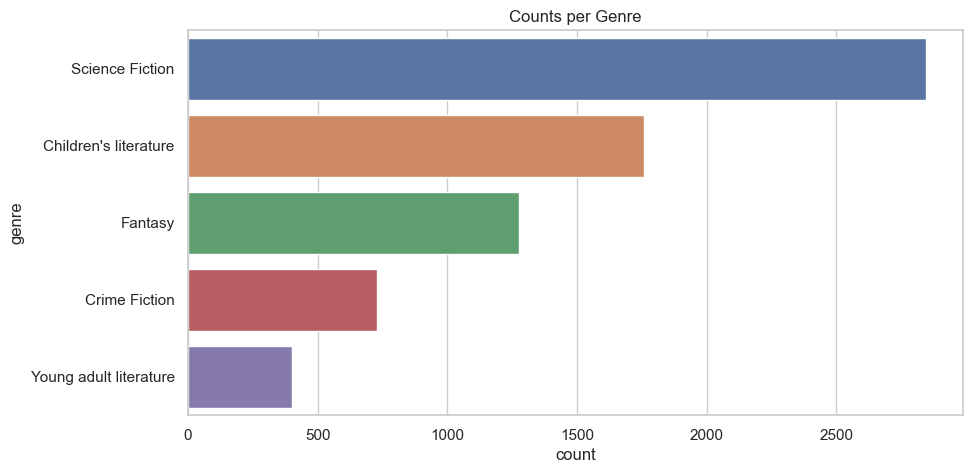

In [16]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.countplot(data=book_df, order=book_df["genre"].value_counts().index, y='genre')
plt.title("Counts per Genre")
plt.show()

Text(0.5, 1.0, 'Length distribution')

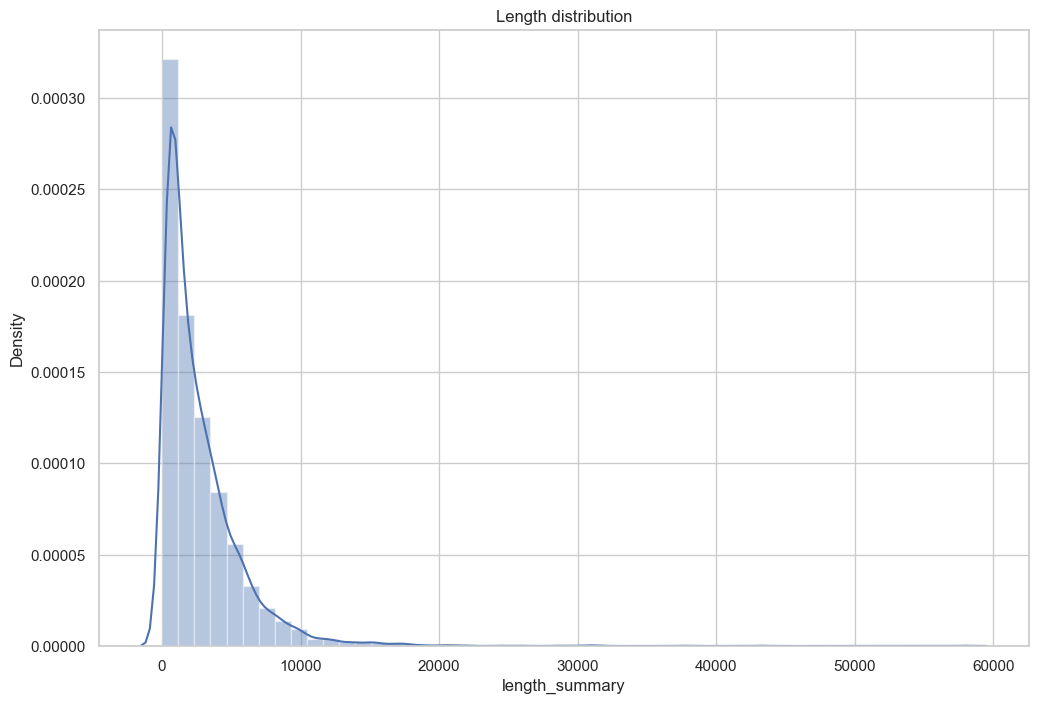

In [17]:
#Calculate posts length
book_df["length_summary"] = book_df["summary"].apply(len)

#Create distribution plot
plt.figure(figsize=(12,8))
sns.distplot(book_df["length_summary"]).set_title("Length distribution")

In [18]:
book_df.iloc[6]['summary']

' Nine years after Emperor Paul Muad\'dib walked into the desert, blind, the ecological transformation of Dune has reached the point where some Fremen are living without stillsuits in the less arid climate and have started to move out of the Sietches and into the villages and cities. As the old ways erode, more and more pilgrims arrive to experience the planet of Muad\'dib. The Imperial high council has lost the political initiative and is powerless to control the Jihad. Paul\'s twin young children, Leto II and Ghanima, sharing his prescience, have concluded that their guardian Alia has succumbed to possession by one of her ancestors and fear that a similar fate awaits them. They (and Alia) also realize that the terraforming of Dune will kill all the sandworms, thus destroying the source of the spice. Leto also fears that, like his father, he will be trapped by his prescience. Possessed by the persona of her grandfather Baron Vladimir Harkonnen, Alia fears that her mother, about to ret

In [19]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Perform count vectorization
cv = CountVectorizer(analyzer="word", max_features=2000, strip_accents='ascii', stop_words=stop_words)

X_cnt = cv.fit_transform(book_df['summary'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Term Frequency Inverse transform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Convert to numpy array
X_cnt.toarray()

#Tfidf object
tfizer = TfidfTransformer()

#Perform Tfid
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

book_df['genre_enc'] = encoder.fit_transform(book_df['genre'])

#Get the labels
Y = book_df['genre_enc']

In [22]:
from sklearn.model_selection import train_test_split

#Create training / testing data split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=7)

In [23]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

LogisticRegression()

In [27]:
lr_pred = lr_model.predict(X_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

#Confusion matrix and Classification Report
def perf_eval(y_true, y_pred):
    #Classification report
    print(classification_report(y_true, y_pred,
                                target_names=list(encoder.classes_)))
    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #Plot the figure
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,
                cmap='Blues',
                annot=True,
                fmt="d",
                xticklabels=list(encoder.classes_),
                yticklabels=list(encoder.classes_))
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

                        precision    recall  f1-score   support

 Children's literature       0.63      0.70      0.66       375
         Crime Fiction       0.89      0.62      0.73       136
               Fantasy       0.64      0.56      0.60       264
       Science Fiction       0.74      0.86      0.80       554
Young adult literature       0.42      0.11      0.17        74

              accuracy                           0.70      1403
             macro avg       0.67      0.57      0.59      1403
          weighted avg       0.69      0.70      0.69      1403



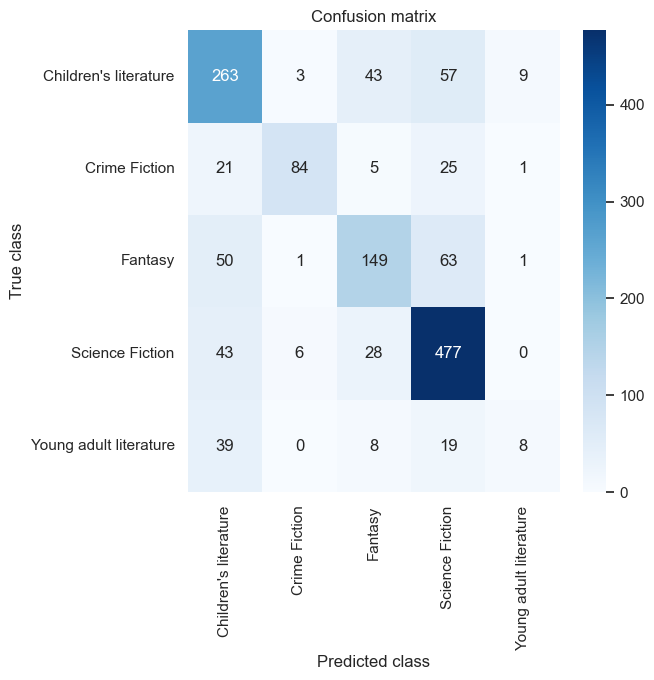

In [29]:
perf_eval(y_test, lr_pred)